In [62]:
# Setup
import numpy as np
import pandas as pd
import warnings
import os

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# classical stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import uniform, loguniform

# sklearn
import sklearn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedKFold, cross_validate, cross_val_predict, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# bayesian
import bambi as bmb
import pymc as pm
import pytensor.tensor as pt
import arviz as az

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 130
np.random.seed(42)

In [43]:
# Load dataset
df = pd.read_csv("data/merged_dengue_dataset.csv")

In [44]:
# Basic cleaning
df_clean = df.dropna(subset=["pre_median_turnaround_days"]).copy()

cols_to_drop = [
    'post_cases', 'post_genome_count', 'post_genomes_per_1000',
    'post_median_turnaround_days', 'overall_median_turnaround_days',
    'pre_genomes_per_1000', 'pre_cases', 'pre_genome_count',
    'treatment_Publicfrac_pred_high', 'treatment_Publicfrac_pred_low',
    'risk_DCZ_pop_risk_upper', 'risk_DCZ_pop_risk_lower',
    'risk_YF_pop_risk_upper', 'risk_YF_pop_risk_lower',
    'income',  # duplicate of group
    'gdp_gdp_usd_mean'  # keep PPP GDP instead
]
df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns], inplace=True)

# Create log_TAT
df_clean['log_TAT'] = np.log(df_clean['pre_median_turnaround_days'])

df_model = df_clean.copy()

In [45]:
# Preprocessing
def build_design_matrix(
    df_model: pd.DataFrame,
    *,
    y_col: str = "log_TAT",
    drop_first: bool = True,
    risk_categories = ("none", "sporadic", "variable", "frequent"),
    group_col: str = "group",
    risk_col: str = "Risk",
    extra_exclude: tuple = ("pre_median_turnaround_days", "country_code", "country_name"),
    verbose: bool = False,
):
    """
    Returns:
      X : pd.DataFrame  -> ready-to-model design matrix
      info : dict        -> metadata e.g. feature names, numeric/cat cols, etc.
    """
    dfw = df_model.copy()

    # figure out columns to consider
    present = set(dfw.columns)
    cat_cols = [c for c in (group_col, risk_col) if c in present]
    exclude = set((y_col,) + tuple(extra_exclude)) | set(cat_cols)

    num_cols = [c for c in dfw.columns
                if c not in exclude and pd.api.types.is_numeric_dtype(dfw[c])]

    # Imputation
    # numerics: median
    if num_cols:
        dfw[num_cols] = dfw[num_cols].fillna(dfw[num_cols].median(numeric_only=True))

    # group: most frequent (mode)
    if group_col in cat_cols:
        mode_val = dfw[group_col].mode(dropna=True)
        mode_val = (mode_val.iloc[0] if not mode_val.empty else "missing")
        dfw[group_col] = dfw[group_col].fillna(mode_val).astype(str)

    # Risk: constant "none" + enforce ordered categories
    if risk_col in cat_cols:
        allowed = set(risk_categories)
        rk = dfw[risk_col].astype(str)
        rk = rk.where(rk.isin(allowed), np.nan).fillna(risk_categories[0])
        dfw[risk_col] = pd.Categorical(rk, categories=list(risk_categories), ordered=True)

    # one-hot encode
    parts = []
    if num_cols:
        parts.append(dfw[num_cols])

    if group_col in cat_cols:
        parts.append(pd.get_dummies(dfw[group_col], prefix=group_col,
                                    drop_first=drop_first, dtype=int))

    if risk_col in cat_cols:
        parts.append(pd.get_dummies(dfw[risk_col], prefix=risk_col,
                                    drop_first=drop_first, dtype=int))

    X = pd.concat(parts, axis=1) if parts else pd.DataFrame(index=dfw.index)

    info = {
        "num_cols": num_cols,
        "cat_cols": cat_cols,
        "feature_names": list(X.columns),
        "risk_categories": list(risk_categories) if risk_col in cat_cols else None,
        "drop_first": drop_first,
    }

    if verbose:
        print(f"Configured ✓ | numerics: {len(num_cols)} | categoricals present: {cat_cols}")
        if risk_col in cat_cols:
            print(f"{risk_col} categories (ordered): {list(risk_categories)}")
            kept = len(risk_categories) - (1 if drop_first else 0)
            dropped = f"(baseline '{risk_categories[0]}' dropped)" if drop_first else "(no drop)"
            print(f"{risk_col} encoding will have {kept} columns {dropped}.")
        print("Total output features:", len(info["feature_names"]))

    return X, info

X, info = build_design_matrix(df_model, drop_first=True, verbose=True)

Configured ✓ | numerics: 14 | categoricals present: ['group', 'Risk']
Risk categories (ordered): ['none', 'sporadic', 'variable', 'frequent']
Risk encoding will have 3 columns (baseline 'none' dropped).
Total output features: 20


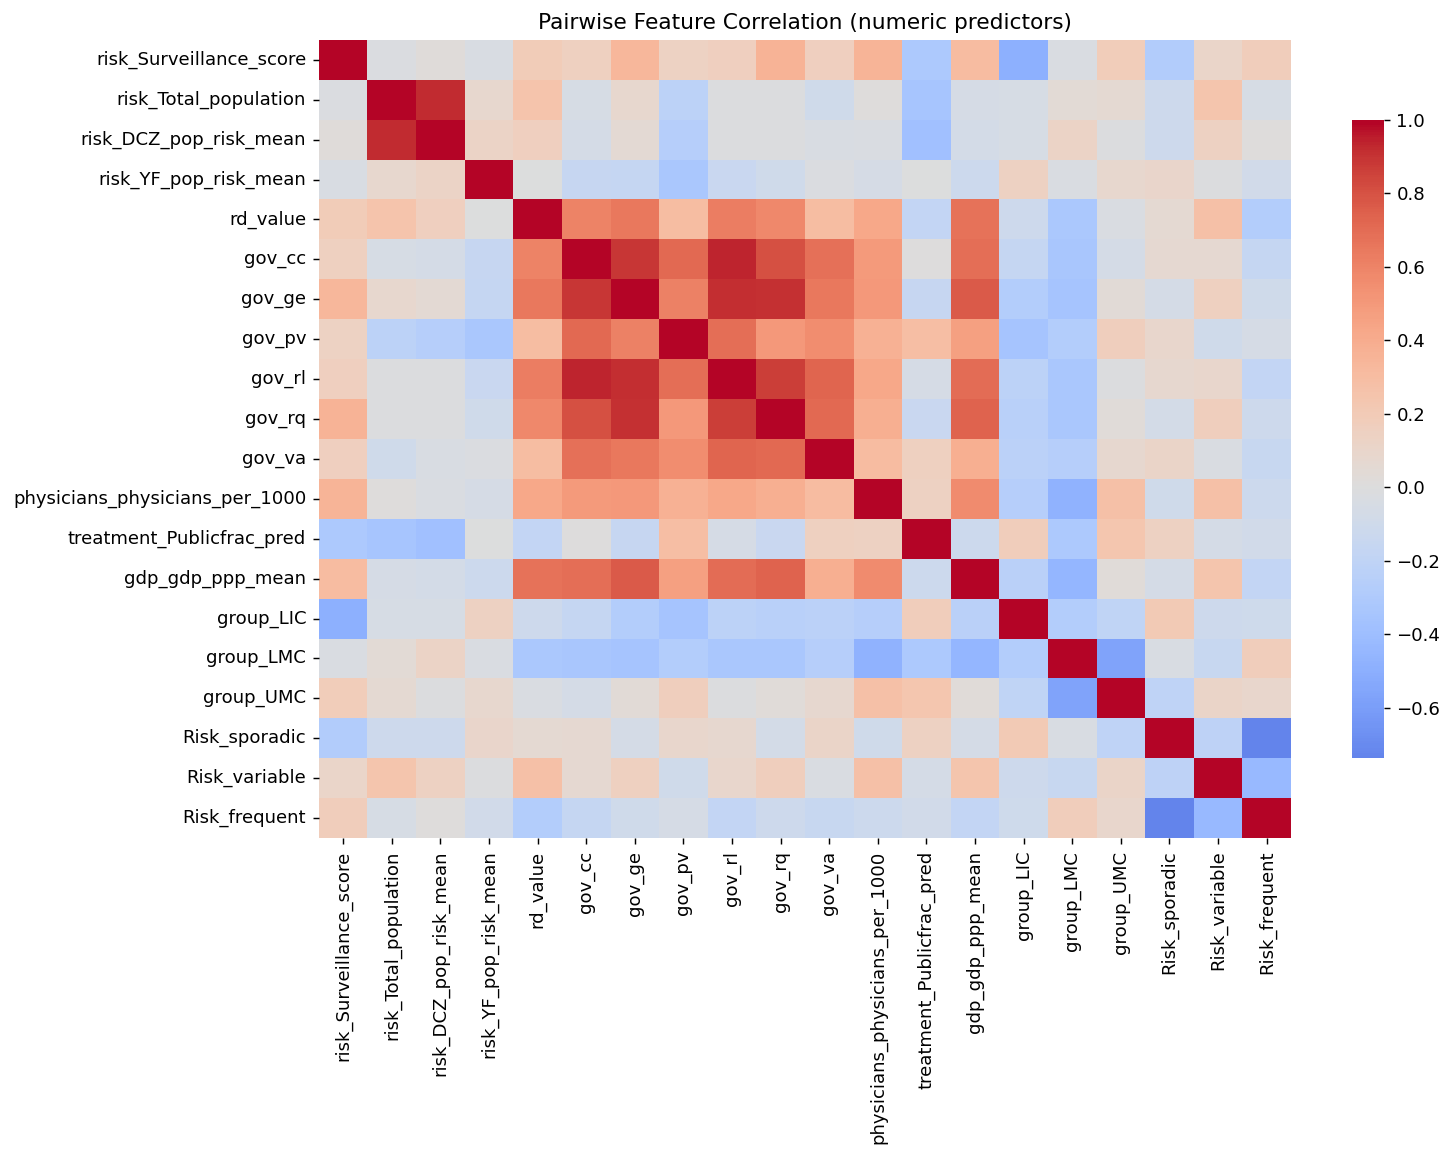

Top 10 absolute correlations:
gov_cc                  gov_rl                    0.938668
gov_rl                  gov_cc                    0.938668
risk_DCZ_pop_risk_mean  risk_Total_population     0.922923
risk_Total_population   risk_DCZ_pop_risk_mean    0.922923
gov_rl                  gov_ge                    0.913886
gov_ge                  gov_rl                    0.913886
                        gov_rq                    0.909167
gov_rq                  gov_ge                    0.909167
gov_cc                  gov_ge                    0.894887
gov_ge                  gov_cc                    0.894887
Name: r, dtype: float64


In [46]:
# 1) Pairwise Correlation
corr = X.corr().clip(-1, 1)  # safety clip
plt.figure(figsize=(12, 9))
sns.heatmap(corr, cmap="coolwarm", center=0, square=False, cbar_kws={"shrink": .8})
plt.title("Pairwise Feature Correlation (numeric predictors)")
plt.tight_layout()
plt.show()

# Quick peek at most correlated pairs (by absolute value)
corr_stack = (
    corr.where(~np.eye(corr.shape[0], dtype=bool))  # drop diagonal
        .stack()
        .rename("r")
        .abs()
        .sort_values(ascending=False)
)
print("Top 10 absolute correlations:")
print(corr_stack.head(10))

In [47]:
# VIF Screening Loop
## EDA only! Not used downstream
def compute_vif_frame(X_df: pd.DataFrame) -> pd.DataFrame:
    X_num = X_df.select_dtypes(include=[np.number]).copy()
    if X_num.empty:
        raise ValueError("VIF expects numeric columns; received none.")

    X_const = sm.add_constant(X_num, has_constant='add')
    vifs = []
    for j, col in enumerate(X_num.columns, start=1):  # skip the added constant at 0
        try:
            v = float(variance_inflation_factor(X_const.values, j))
        except Exception:
            v = np.nan
        vifs.append((col, v))
    out = pd.DataFrame(vifs, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)
    return out

# Drop any zero-variance columns first (VIF undefined if var=0)
zero_var = X.columns[X.nunique(dropna=True) <= 1].tolist()
if zero_var:
    print("Dropping zero-variance predictors:", zero_var)
    X = X.drop(columns=zero_var)

print(f"VIF screening removed {len(dropped)} feature(s): {dropped}")
print(f"Remaining #features after VIF: {X.shape[1]}")
vif_final = compute_vif_frame(X)
vif_final.head(10)

VIF screening removed 7 feature(s): [('gov_rl', 19.729506311130276), ('gov_ge', 14.954771596651035), ('Risk_frequent', 12.588639133535224), ('risk_Total_population', 10.316424033823075), ('gov_cc', 8.122484989890806), ('group_LMC', 5.870021351629044), ('gov_rq', 5.599945118202881)]
Remaining #features after VIF: 20


,feature,VIF
8,gov_rl,19.729506
6,gov_ge,15.626129
5,gov_cc,14.014615
19,Risk_frequent,12.774978
9,gov_rq,11.860868
1,risk_Total_population,11.278946
17,Risk_sporadic,10.928308
2,risk_DCZ_pop_risk_mean,10.133461
13,gdp_gdp_ppp_mean,6.489048
15,group_LMC,6.051872


In [57]:
# Set X and Y
X_full = X.copy()                       
y = df_model["log_TAT"].to_numpy()

print(X_full.shape, "features x rows:", X_full.shape[1], "x", X_full.shape[0])

(82, 20) features x rows: 20 x 82


In [61]:
## Let's check with an ElasticNet
# Outer CV (honest performance estimate), Inner CV (tuning)
outer = KFold(n_splits=5, shuffle=True, random_state=42)   # no repeats
inner = KFold(n_splits=3, shuffle=True, random_state=42)

enet_pipe = Pipeline([
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("model", ElasticNet(max_iter=5000, tol=1e-3, random_state=42)),
])

# Randomised search
param_dist = {
    "model__alpha": loguniform(1e-4, 1e1),     
    "model__l1_ratio": uniform(0.05, 0.90),   
}

search_tpl = RandomizedSearchCV(
    estimator=enet_pipe,
    param_distributions=param_dist,
    n_iter=40,               
    cv=inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=max(1, os.cpu_count()//2),   # be kind to my laptop fans
    refit=True,
    verbose=1,
    random_state=42,
    pre_dispatch="2*n_jobs",
)

# Nested CV with out-of-fold predictions
y_pred_oof = np.empty_like(y, dtype=float)
params_seen = []

for tr, te in outer.split(X_full):
    gs = clone(search_tpl)
    gs.fit(X_full.iloc[tr], y[tr])
    y_pred_oof[te] = gs.predict(X_full.iloc[te])
    params_seen.append(gs.best_params_)

rmse = np.sqrt(mean_squared_error(y, y_pred_oof))
mae  = mean_absolute_error(y, y_pred_oof)
r2   = r2_score(y, y_pred_oof)
print(f"[ElasticNet nested CV] RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

# Final refit on all data with a fresh randomised search
gs_full = clone(search_tpl)
gs_full.fit(X_full, y)
best_enet = gs_full.best_estimator_
print("Best params on full data:", gs_full.best_params_)

coef = best_enet.named_steps["model"].coef_
coef_ser = pd.Series(coef, index=X_full.columns).sort_values(key=np.abs, ascending=False)
display(coef_ser.to_frame("coef").head(15))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[ElasticNet nested CV] RMSE=0.549, MAE=0.403, R²=-0.001
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params on full data: {'model__alpha': np.float64(0.2637333993381525), 'model__l1_ratio': np.float64(0.4461372443656412)}


,coef
Risk_variable,-0.040784
Risk_frequent,0.032045
gov_va,0.000398
risk_Surveillance_score,0.000000
risk_YF_pop_risk_mean,-0.000000
risk_DCZ_pop_risk_mean,-0.000000
risk_Total_population,-0.000000
rd_value,0.000000
gov_pv,0.000000
gov_rl,0.000000


In [67]:
# Bayesian model + LOO
# Build standardised design matrix Z for Bayes
from sklearn.preprocessing import StandardScaler
scaler_bayes = StandardScaler(with_mean=True, with_std=True).fit(X_full)
Z = scaler_bayes.transform(X_full)
feature_names = list(X_full.columns)

# Centre y
y_mean = y.mean()
y_c = y - y_mean

n, p = Z.shape
p0 = 2  # based on your ENet result
tau0 = (p0 / (p - p0)) * (1 / np.sqrt(n))  # Piironen–Vehtari heuristic

with pm.Model() as hs_model:
    # Intercept (unpenalised)
    alpha = pm.Normal("alpha", mu=0.0, sigma=1.0)

    # Regularised horseshoe prior
    lam = pm.HalfCauchy("lam", beta=1.0, shape=p)        # local scales λ_j
    tau = pm.HalfCauchy("tau", beta=tau0)                # global scale τ
    c2  = pm.InverseGamma("c2", alpha=2.0, beta=2.0)     # slab scale^2
    z   = pm.Normal("z", mu=0.0, sigma=1.0, shape=p)     # latent normals

    shrink = pt.sqrt(c2 / (c2 + (tau**2) * (lam**2)))    # regularisation factor
    beta = pm.Deterministic("beta", z * lam * tau * shrink)

    # Robust likelihood on centred y
    mu = alpha + pm.math.dot(Z, beta)
    sigma = pm.HalfStudentT("sigma", nu=3, sigma=1.0)
    nu = pm.Exponential("nu", lam=1/30)                  # dof for Student-t
    y_obs = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=y_c)

    # Ask PyMC to keep pointwise log-likelihood in the InferenceData
    idata_hs = pm.sample(
        draws=2000, tune=2000, chains=4, cores=4,
        target_accept=0.9, random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},
    )

# Quick check of what's inside the InferenceData
print(idata_hs)
print("Groups:", idata_hs.groups())
print("Log-likelihood vars:", list(idata_hs.log_likelihood.data_vars))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, lam, tau, c2, z, sigma, nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 143 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data


TypeError: argument of type 'method' is not iterable

Sampling: [y]


Computed from 8000 posterior samples and 82 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -66.52     9.15
p_loo       12.45        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       81   98.8%
   (0.70, 1]   (bad)         1    1.2%
   (1, Inf)   (very bad)    0    0.0%

PSIS-k > 0.7: 1 obs -> indices: [34]


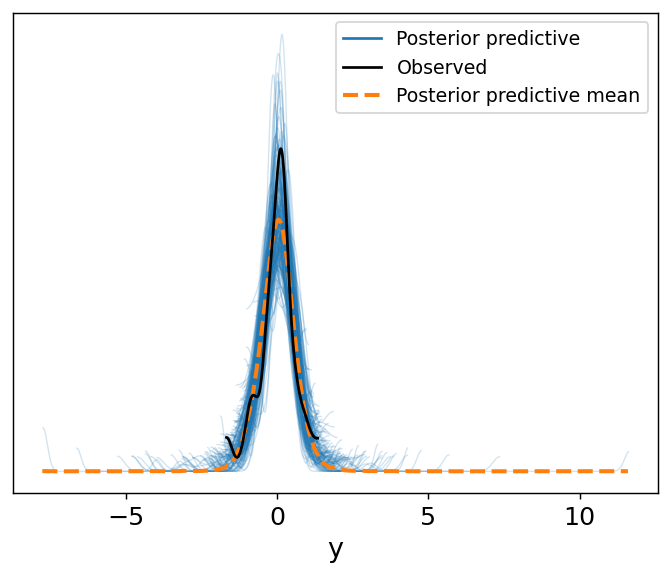

In [68]:
# Posterior predictive:
with hs_model:
    idata_hs = pm.sample_posterior_predictive(
        idata_hs, var_names=["y"], extend_inferencedata=True
    )

# LOO & PSIS-k:
loo = az.loo(idata_hs, pointwise=True)
print(loo)

k = loo.pareto_k.values
bad = np.where(k > 0.7)[0]
print(f"PSIS-k > 0.7: {len(bad)} obs -> indices: {bad[:10]}")

# PPC plot (log scale, centred):
az.plot_ppc(idata_hs, kind="kde", num_pp_samples=200);

PSIS-k > 0.7: 1 obs -> indices: [34]
Row info for influential obs:


,country_code,Risk,group,pre_median_turnaround_days,log_TAT
34,IND,frequent,LMC,1213.0,7.100852


Standardised design row:


,value
risk_Surveillance_score,0.693000
risk_Total_population,1376.711000
risk_DCZ_pop_risk_mean,1355.866000
risk_YF_pop_risk_mean,0.000000
rd_value,0.699045
gov_cc,-0.382857
gov_ge,0.110714
gov_pv,-0.957143
gov_rl,-0.029286
gov_rq,-0.285000


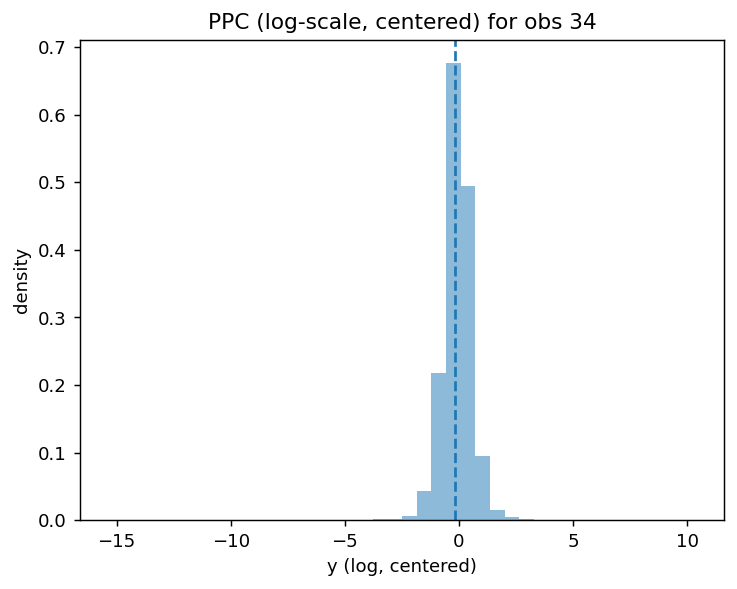

In [77]:
# Recompute PSIS-LOO diagnostics and inspect influential observations (k > 0.7)
# Make sure pointwise log-likelihood is stored
if "log_likelihood" not in idata_hs.groups():
    with hs_model:
        idata_hs = pm.compute_log_likelihood(idata_hs, var_names=["y"])

# 2) LOO + Pareto-k
loo = az.loo(idata_hs, pointwise=True)
k = loo.pareto_k.values
bad_idx = np.flatnonzero(k > 0.7)
print(f"PSIS-k > 0.7: {bad_idx.size} obs -> indices: {bad_idx[:10]}")

# 3) Inspect the first influential case
if bad_idx.size:
    ix = int(bad_idx[0])
    assert len(df_model) == len(X_full), "df_model and X_full are misaligned"

    id_cols = [c for c in ["country_name", "country", "country_code", "iso3"] if c in df_model.columns]
    cols_to_show = id_cols + [c for c in ["Risk", "group", "pre_median_turnaround_days", "log_TAT"] if c in df_model.columns]
    print("Row info for influential obs:")
    display(df_model.iloc[ix][cols_to_show].to_frame().T)

    print("Standardised design row:")
    display(X_full.iloc[ix].to_frame("value"))

    # Quick PPC overlay for that single obs (log scale, centred)
    y_ppc_log = idata_hs.posterior_predictive["y"].stack(sample=("chain","draw")).values
    y_obs_log = y_c[ix]

    plt.figure()
    plt.hist(y_ppc_log[ix, :], bins=40, density=True, alpha=0.5)
    plt.axvline(y_obs_log, linestyle="--")
    plt.title(f"PPC (log-scale, centered) for obs {ix}")
    plt.xlabel("y (log, centered)"); plt.ylabel("density")
    plt.show()
else:
    print("No influential observations with k > 0.7.")

In [70]:
# posterior predictive on centered log scale
y_ppc_log = idata_hs.posterior_predictive["y"].stack(sample=("chain","draw")).values  # (n, S)

# back to days
y_draws_days = np.exp(y_ppc_log + y_mean)

pred_median_days = np.median(y_draws_days, axis=1)
pred_q05, pred_q95 = np.quantile(y_draws_days, [0.05, 0.95], axis=1)

pred_df = pd.DataFrame({
    "pred_days_med": pred_median_days,
    "pred_days_q05": pred_q05,
    "pred_days_q95": pred_q95,
}, index=df_model.index)

pred_df.head(10)

,pred_days_med,pred_days_q05,pred_days_q95
0,893.464212,358.432341,2452.153150
2,956.217504,376.336089,2606.256207
3,1096.030954,432.326635,3057.357216
4,1421.690589,595.371093,3355.650449
5,1397.604288,602.332277,3334.085485
6,1396.376764,603.504513,3257.009884
7,1520.513857,645.249792,3486.506418
8,1462.647825,580.379080,3569.018245
9,1558.807448,668.180213,3633.018047
10,820.047549,316.874140,2330.256863


In [76]:
# Sensitivity check on horseshoe prior
def fit_rhs_with_p0(Z, y_c, p0):
    n, p = Z.shape
    tau0 = (p0 / (p - p0)) * (1 / np.sqrt(n))
    with pm.Model() as m:
        alpha = pm.Normal("alpha", 0, 1)
        lam = pm.HalfCauchy("lam", 1.0, shape=p)
        tau = pm.HalfCauchy("tau", tau0)
        c2  = pm.InverseGamma("c2", 2, 2)
        z   = pm.Normal("z", 0, 1, shape=p)
        shrink = pm.math.sqrt(c2 / (c2 + (tau**2)*(lam**2)))
        beta = pm.Deterministic("beta", z * lam * tau * shrink)
        sigma = pm.HalfStudentT("sigma", 3, 1)
        nu = pm.Exponential("nu", 1/30)
        mu = alpha + pm.math.dot(Z, beta)
        y_obs = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=y_c)
        idata = pm.sample(1500, tune=1500, chains=4, cores=4, target_accept=0.95,
                          return_inferencedata=True, idata_kwargs={"log_likelihood": True},
                          random_seed=42)
    return idata

cands = {f"HS p0={k}": fit_rhs_with_p0(Z, y_c, k) for k in [1, 2, 4]}
az.compare(cands, ic="loo")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, lam, tau, c2, z, sigma, nu]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 155 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, lam, tau, c2, z, sigma, nu]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 111 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, lam, tau, c2, z, sigma, nu]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 141 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
HS p0=4,0,-66.194810,13.064276,0.000000,1.000000e+00,9.173472,0.000000,False,log
HS p0=2,1,-66.431353,12.635328,0.236542,3.608225e-16,9.189647,0.258010,True,log
HS p0=1,2,-66.957975,12.145660,0.763164,1.110223e-16,9.051340,0.589844,True,log


In [78]:
# Investigate sensitivity results
idata_p1, idata_p2, idata_p4 = cands["HS p0=1"], cands["HS p0=2"], cands["HS p0=4"]

def diag(name, idata):
    loo = az.loo(idata, pointwise=True)
    k = loo.pareto_k.values
    n_bad = int((k > 0.7).sum())
    div = int(idata.sample_stats["diverging"].sum().values)
    rhat_max = float(az.summary(idata)["r_hat"].max())
    return name, loo.elpd_loo, loo.se, loo.p_loo, n_bad, div, rhat_max

for name, idata in [("HS p0=1", idata_p1), ("HS p0=2", idata_p2), ("HS p0=4", idata_p4)]:
    print(diag(name, idata))

('HS p0=1', np.float64(-66.9579746748777), np.float64(9.051340490054578), np.float64(12.145660271595126), 2, 0, 1.0)
('HS p0=2', np.float64(-66.43135289262024), np.float64(9.189646741471236), np.float64(12.635328135859424), 1, 2, 1.0)
('HS p0=4', np.float64(-66.19481044259523), np.float64(9.173471675788882), np.float64(13.064276173529308), 0, 2, 1.0)


In [82]:
# Check best run
idata = idata_p4  # best run from sensitivity check
bet = idata.posterior["beta"].stack(sample=("chain","draw")).values

beta_mean = bet.mean(axis=1)
beta_hdi  = az.hdi(bet.T, hdi_prob=0.95)  # (p,2)
pr_pos    = (bet > 0).mean(axis=1)

coef_tbl = pd.DataFrame({
    "feature": X_full.columns,
    "mean": beta_mean,
    "hdi_low": beta_hdi[:,0],
    "hdi_high": beta_hdi[:,1],
    "Pr(beta>0)": pr_pos,
}).sort_values("mean", key=np.abs, ascending=False)

# Focus on the Risk dummies reported in ElasticNet
mask = coef_tbl["feature"].str.startswith("Risk_")
display(coef_tbl[mask])

,feature,mean,hdi_low,hdi_high,Pr(beta>0)
18,Risk_variable,-0.128649,-0.292450,0.016232,0.098167
19,Risk_frequent,0.040495,-0.038326,0.194371,0.741667
17,Risk_sporadic,-0.002947,-0.091705,0.069065,0.430000


In [83]:
# Fit & compare: RHS vs Laplace vs ARD
# Helpers

def fit_rhs(Z, y_c, p0=4, target_accept=0.95, draws=2000, tune=2000, seed=42, student_t=True):
    Z = np.asarray(Z, dtype=float); y_c = np.asarray(y_c, dtype=float)
    n, p = Z.shape
    tau0 = (p0 / (p - p0)) * (1 / np.sqrt(n))
    with pm.Model() as m:
        alpha = pm.Normal("alpha", 0, 1)
        lam = pm.HalfCauchy("lam", 1.0, shape=p)
        tau = pm.HalfNormal("tau", sigma=tau0)          # stable global
        c2  = pm.InverseGamma("c2", 2, 2)
        z   = pm.Normal("z", 0, 1, shape=p)
        shrink = pt.sqrt(c2 / (c2 + (tau**2)*(lam**2)))
        beta = pm.Deterministic("beta", z * lam * tau * shrink)

        mu = alpha + pm.math.dot(Z, beta)
        if student_t:
            sigma = pm.HalfStudentT("sigma", 3, 1)
            nu = pm.Exponential("nu", 1/30)
            pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=y_c)
        else:
            sigma = pm.HalfNormal("sigma", 1)
            pm.Normal("y", mu=mu, sigma=sigma, observed=y_c)

        idata = pm.sample(draws=draws, tune=tune, chains=4, cores=4,
                          target_accept=target_accept, random_seed=seed,
                          return_inferencedata=True, idata_kwargs={"log_likelihood": True})
        idata = pm.sample_posterior_predictive(idata, var_names=["y"], extend_inferencedata=True)
    return idata

def fit_laplace(Z, y_c, target_accept=0.95, draws=2000, tune=2000, seed=42):
    Z = np.asarray(Z, dtype=float); y_c = np.asarray(y_c, dtype=float)
    n, p = Z.shape
    with pm.Model() as m:
        alpha = pm.Normal("alpha", 0, 1)
        b = pm.HalfNormal("b", 1.0)
        beta = pm.Laplace("beta", 0, b, shape=p)
        sigma = pm.HalfStudentT("sigma", 3, 1)
        nu = pm.Exponential("nu", 1/30)
        pm.StudentT("y", mu=alpha + pm.math.dot(Z, beta), sigma=sigma, nu=nu, observed=y_c)

        idata = pm.sample(draws=draws, tune=tune, chains=4, cores=4,
                          target_accept=target_accept, random_seed=seed,
                          return_inferencedata=True, idata_kwargs={"log_likelihood": True})
        idata = pm.sample_posterior_predictive(idata, var_names=["y"], extend_inferencedata=True)
    return idata

def fit_ard(Z, y_c, target_accept=0.95, draws=2000, tune=2000, seed=42):
    Z = np.asarray(Z, dtype=float); y_c = np.asarray(y_c, dtype=float)
    n, p = Z.shape
    with pm.Model() as m:
        alpha = pm.Normal("alpha", 0, 1)
        tau = pm.Gamma("tau", 2.0, 2.0, shape=p)
        beta = pm.Normal("beta", 0, pm.math.sqrt(1.0/tau), shape=p)
        sigma = pm.HalfStudentT("sigma", 3, 1)
        nu = pm.Exponential("nu", 1/30)
        pm.StudentT("y", mu=alpha + pm.math.dot(Z, beta), sigma=sigma, nu=nu, observed=y_c)

        idata = pm.sample(draws=draws, tune=tune, chains=4, cores=4,
                          target_accept=target_accept, random_seed=seed,
                          return_inferencedata=True, idata_kwargs={"log_likelihood": True})
        idata = pm.sample_posterior_predictive(idata, var_names=["y"], extend_inferencedata=True)
    return idata

def compare_models(models: dict):
    """LOO table + basic diagnostics for each model"""
    comp = az.compare(models, ic="loo")
    display(comp)

    for name, idata in models.items():
        loo = az.loo(idata, pointwise=True)
        k = loo.pareto_k.values
        n_bad = int((k > 0.7).sum())
        div = int(idata.sample_stats["diverging"].sum().values)
        rhat_max = float(az.summary(idata)["r_hat"].max())
        print(f"[{name}] elpd_loo={loo.elpd_loo:.2f} (se={loo.se:.2f}), "
              f"p_loo={loo.p_loo:.2f}, k>0.7: {n_bad}, divergences: {div}, max R-hat: {rhat_max:.3f}")
    return comp

# Fit all three
idata_rhs = fit_rhs(Z, y_c, p0=4, target_accept=0.95)   # best HS
idata_lap = fit_laplace(Z, y_c, target_accept=0.95)
idata_ard = fit_ard(Z, y_c, target_accept=0.95)

# Compare by LOO
comp = compare_models({"RHS p0=4": idata_rhs, "Laplace": idata_lap, "ARD": idata_ard})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, lam, tau, c2, z, sigma, nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 121 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, b, beta, sigma, nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 176 seconds.
Sampling: [y]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, beta, sigma, nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 107 seconds.
Sampling: [y]


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Laplace,0,-65.262675,13.248006,0.000000,1.000000e+00,9.047781,0.000000,False,log
RHS p0=4,1,-65.999425,13.013429,0.736749,5.551115e-17,9.232101,1.173071,True,log
ARD,2,-76.495099,30.649471,11.232423,0.000000e+00,9.413554,4.758374,True,log


[RHS p0=4] elpd_loo=-66.00 (se=9.23), p_loo=13.01, k>0.7: 2, divergences: 1, max R-hat: 1.000
[Laplace] elpd_loo=-65.26 (se=9.05), p_loo=13.25, k>0.7: 0, divergences: 0, max R-hat: 1.000
[ARD] elpd_loo=-76.50 (se=9.41), p_loo=30.65, k>0.7: 3, divergences: 0, max R-hat: 1.000


In [84]:
# Pick the top by LOO:
best_name = comp.index[0]
best = {"RHS p0=4": idata_rhs, "Laplace": idata_lap, "ARD": idata_ard}[best_name]

bet = best.posterior["beta"].stack(sample=("chain","draw")).values  # (p, S)
beta_mean = bet.mean(axis=1)
beta_hdi  = az.hdi(bet.T, hdi_prob=0.95)
pr_pos    = (bet > 0).mean(axis=1)

coef_tbl = pd.DataFrame({
    "feature": feature_names,
    "mean": beta_mean,
    "hdi_low": beta_hdi[:,0],
    "hdi_high": beta_hdi[:,1],
    "Pr(beta>0)": pr_pos,
}).sort_values("mean", key=np.abs, ascending=False)

display(best_name, coef_tbl.head(15))

'Laplace'

,feature,mean,hdi_low,hdi_high,Pr(beta>0)
18,Risk_variable,-0.100026,-0.239933,0.022093,0.054375
19,Risk_frequent,0.057211,-0.043979,0.192252,0.845875
10,gov_va,0.046767,-0.047282,0.162632,0.815750
12,treatment_Publicfrac_pred,0.041672,-0.041473,0.143229,0.813000
6,gov_ge,0.039318,-0.066446,0.187967,0.724625
3,risk_YF_pop_risk_mean,-0.036859,-0.119441,0.038706,0.179375
1,risk_Total_population,-0.028488,-0.140936,0.057372,0.271500
14,group_LIC,-0.025996,-0.129964,0.053431,0.275875
13,gdp_gdp_ppp_mean,-0.022817,-0.147994,0.084184,0.345625
0,risk_Surveillance_score,0.022695,-0.055318,0.106529,0.711875
